# Analysis of a small game

In [47]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
import nashpy as nash

"""
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.serif'] = ['CMU Serif']
plt.rc('axes', unicode_minus=False)
plt.rcParams['text.usetex'] = True
"""

from matplotlib import rcParams, rcParamsDefault
rcParams.update(rcParamsDefault)

Computation of utilities for one festival:

In [48]:
def compute_utilities(strategy_1, strategy_2, n_players, n_concerts, n_lines, n_timesteps, utilities):

    front_row_utility = utilities[0]
    back_row_utility = utilities[1]
    same_row_utility = utilities[2]
    start_utility = utilities[3]
    waiting_utility = utilities[4]

    utilities = np.zeros(n_players)
    strategies = [strategy_1, strategy_2]

    positions_which_concert = np.zeros(n_players)
    positions_which_line = np.ones(n_players, dtype = float) * np.mean(sum(range(1,n_lines + 1))) # assume mean line value for every player in first concert
    time_spent_at_current_stage = np.zeros(n_players)

    # iterate through time
    for time in range(n_timesteps):
        
        # update positions
        for player in range(n_players):

            player_strategy = strategies[player]
            
            # check if player will move
            moved = 0
            for i in range(len(player_strategy)):

                if (player_strategy[i] == time):
                    positions_which_concert[player] = i + 1 # eg player_strategy[i] = 0 means go to concert 1 at time 0. 
                    time_spent_at_current_stage[player] = 0
                    moved = 1

            # increase time at current stage
            if(not moved):
                time_spent_at_current_stage[player] = time_spent_at_current_stage[player] + 1

        # check which line each player is at
        for concert in range(n_concerts):
            players = list(np.where(positions_which_concert == concert)[0])
           
            if(len(players) > 0):

                count_players = 0
           
                for time_spent in range(int(max(time_spent_at_current_stage[players])),-1, -1):
                    players_who_spent_this_time = list(np.where(time_spent_at_current_stage == time_spent)[0])
                    players_correct_time_and_stage = list(np.intersect1d(players, players_who_spent_this_time))
               
                    n_players_same_time = len(players_correct_time_and_stage)
                    
                    if (n_players_same_time > 0):
                        # assuming two players
                        if (n_players_same_time == 1 and count_players == 0):
                            positions_which_line[players_correct_time_and_stage] = front_row_utility
                            count_players += 1
                        elif (n_players_same_time == 1 and count_players == 1):
                            positions_which_line[players_correct_time_and_stage] = back_row_utility
                        else:
                            positions_which_line[players_correct_time_and_stage] = same_row_utility
    
        # check current concert and update utilities for each player
        for player in range(n_players):
            if (positions_which_concert[player] == time):
                if(time == 0):
                    utilities[player] += start_utility
                else:
                    utilities[player] += positions_which_line[player]
            else:
                utilities[player] += waiting_utility

    return utilities


Simulation of one festival to obtain normal form:

In [52]:
def simulate_festival(utilities_param):
    n_concerts = 3
    n_lines = 2
    n_players = 2
    timesteps = list(range(n_concerts))
    n_timesteps = n_concerts

    actions = list(itertools.combinations_with_replacement(timesteps, n_concerts - 1))
    actions.pop(1)
    actions.pop(-1)
    print(actions)
    print()
    n_actions = len(actions)
    
    utilities_normal_form_P1 = np.zeros((n_actions, n_actions))
    utilities_normal_form_P2 = np.zeros((n_actions, n_actions))

    for i in range(n_actions):
        for j in range(n_actions):
            utilities = compute_utilities(actions[i], actions[j], n_players, n_concerts, n_lines, n_timesteps, utilities_param)
            utilities_normal_form_P1[i][j] = utilities[0]
            utilities_normal_form_P2[i][j] = utilities[1]

    print("Normal form P1")
    print(utilities_normal_form_P1)
    print()
    print("Normal form P2")
    print(utilities_normal_form_P2)

    return utilities_normal_form_P1, utilities_normal_form_P2


Compute evolutionary stable strategies (pure ones)

[(0, 0), (0, 2), (1, 1), (1, 2)]

Normal form P1
[[-3.  0.  0.  0.]
 [ 3.  0.  3.  3.]
 [-1.  2. -1.  2.]
 [ 5.  2.  5.  2.]]

Normal form P2
[[-3.  3. -1.  5.]
 [ 0.  0.  2.  2.]
 [ 0.  3. -1.  5.]
 [ 0.  3.  2.  2.]]
num eq:  3
(array([0., 1., 0., 0.]), array([0., 0., 0., 1.]))
(array([0., 0., 0., 1.]), array([0., 1., 0., 0.]))
(array([-0.        ,  0.33333333,  0.        ,  0.66666667]), array([-0.        ,  0.33333333,  0.        ,  0.66666667]))

Equilibria
[[ 0.          1.          0.          0.        ]
 [ 0.          0.          0.          1.        ]
 [-0.          0.33333333  0.          0.66666667]]


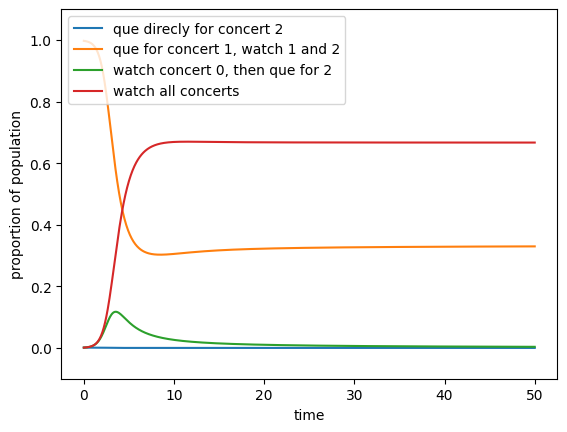

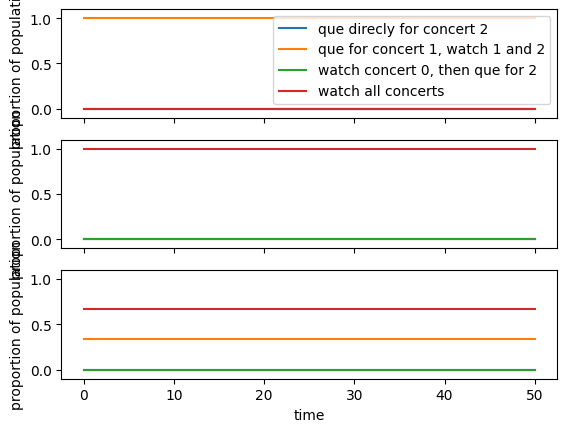

In [ ]:
# parameters
front_row_utility = 10
back_row_utility = 2
same_row_utility = 2.5
start_utility = 2.5
waiting_utility = -1

"""
front_row_utility = 4
back_row_utility = 1
same_row_utility = 1
start_utility = 0
waiting_utility = -2
"""

utilities_param = [front_row_utility, back_row_utility, same_row_utility, start_utility, waiting_utility]
n_actions = 4

# simulate to get normal form
utilities_normal_form_P1, utilities_normal_form_P2 = simulate_festival(utilities_param)

# compute nash equilibria
game = nash.Game(utilities_normal_form_P1, utilities_normal_form_P2)
equilibria = game.support_enumeration()
n_eq = sum(1 for _ in equilibria)
print("num eq: ", n_eq)

equilibria = game.support_enumeration() # reset generator
equilibria_start = np.zeros((n_eq, 4))
eq_counter = 0
for eq in equilibria:
    print(eq)
    equilibria_start[eq_counter,:] = eq[0]
    eq_counter += 1

print()
print("Equilibria")
print(equilibria_start)

# evolutionary simulation
#initial_pop = np.array([0.25, 0.25, 0.25, 0.25])
#initial_pop = np.array([0.05, 0.05, 0.85, 0.05])
#initial_pop = np.array([0.05, 0.05, 0.05, 0.85])
initial_pop = np.array([0.001,0.997,0.001,0.001])

time = np.linspace(0, 50, 1000)
populations = game.replicator_dynamics(y0 = initial_pop, timepoints = time).T

labels = ["que direcly for concert 2", "que for concert 1, watch 1 and 2", "watch concert 0, then que for 2", "watch all concerts"]
fig, axes = plt.subplots(1,1)
for k in range(n_actions):
    
    axes.plot(time, populations[k], label = labels[k])
    
    axes.set_ylabel(r'proportion of population')
    axes.set_xlabel(r'time')
    axes.set_ylim([-0.1,1.1])
axes.legend(loc = "upper left")
plt.show()

# plot evolutionary result
fig, axes = plt.subplots(n_eq,1, sharex="col")
eq_counter = 0
for i in range(0, n_eq):
    initial_pop = equilibria_start[eq_counter,:]
    eq_counter += 1
    populations = game.replicator_dynamics(y0 = initial_pop, timepoints = time).T

    for k in range(n_actions):
        axes[i].plot(time, populations[k], label = labels[k])
        axes[i].set_ylim([-0.1,1.1])

    if (eq_counter > n_eq - 1):
        break

axes[0].legend(loc = "upper right")
axes[0].set_ylabel(r'proportion of population')
axes[1].set_ylabel(r'proportion of population')
axes[2].set_ylabel(r'proportion of population')
axes[2].set_xlabel(r'time')

plt.show()


[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (6, 6), (6, 7), (6, 8), (6, 9), (7, 7), (7, 8), (7, 9), (8, 8), (8, 9), (9, 9)]

55
Normal form P1
[[ 0.  8.  8. ...  8.  8.  8.]
 [-2.  0.  8. ...  8.  8.  8.]
 [ 9.  9.  3. ... 19. 19. 19.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]

Normal form P2
[[ 0. -2.  9. ...  0.  0.  0.]
 [ 8.  0.  9. ...  0.  0.  0.]
 [ 8.  8.  3. ...  0.  0.  0.]
 ...
 [ 8.  8. 19. ...  0.  0.  0.]
 [ 8.  8. 19. ...  0.  0.  0.]
 [ 8.  8. 19. ...  0.  0.  0.]]
(55, 1000)


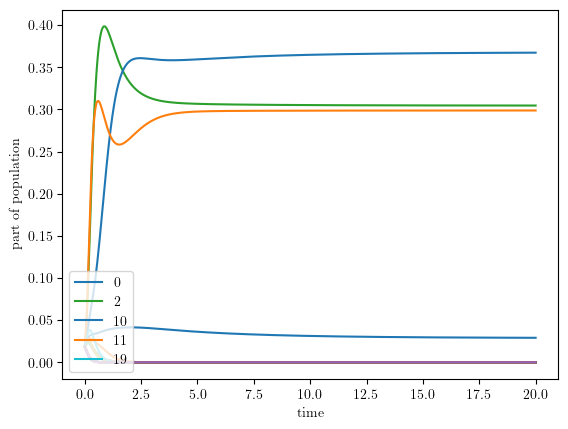

In [39]:
front_row_utility = 10
back_row_utility = 0
same_row_utility = 2
start_utility = 2
waiting_utility = -1
utilities_param = [front_row_utility, back_row_utility, same_row_utility, start_utility, waiting_utility]
n_actions = 55

# simulate to get normal form
utilities_normal_form_P1, utilities_normal_form_P2 = simulate_festival(utilities_param)

# compute nash equilibria
game = nash.Game(utilities_normal_form_P1, utilities_normal_form_P2)

"""
equilibria = game.support_enumeration()
n_eq = sum(1 for _ in equilibria)


equilibria = game.support_enumeration() # reset generator
equilibria_start = np.zeros((5, 4))
eq_counter = 0
for eq in equilibria:
    print(eq)
    equilibria_start[eq_counter,:] = eq[0]
    eq_counter += 1

print()
print("Equilibria")
print(equilibria_start)
""""project_Mathilda copy 2.ipynb"

# evolutionary simulation
#initial_pop = np.array([0.25, 0.25, 0.25, 0.25])
initial_pop = np.ones(n_actions)*1/n_actions
# initial_pop = equilibria_start[2,:]
time = np.linspace(0, 20, 1000)
populations = game.replicator_dynamics(y0 = initial_pop, timepoints = time).T
print(populations.shape)
# plot evolutionary result
fig, axes = plt.subplots(1,1)

#labels = ["que direcly for concert 2", "que for concert 1, watch 1 and 2", "watch concert 0, then que for 2", "watch all concerts"]
best_values = np.argsort(populations[:, -1])
best5 = best_values[-5:]

for k in range(n_actions):
    
    if(k in best5):
        axes.plot(time, populations[k], label = k)
    else:
        axes.plot(time, populations[k])
    axes.legend(loc = "lower left")
    axes.set_ylabel(r'part of population')
    axes.set_xlabel(r'time')
    #axes.set_ylim([-0.1,1.1])

#max_values = np.argmax(populations[:,-1])

#print(max_values)

#print(np.ar(populations[:,-1], ))


plt.show()